In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import Sequence

from datetime import datetime
from scipy.optimize import linear_sum_assignment
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import os
from scipy.optimize import linear_sum_assignment as lsa
from imgaug import augmenters as iaa
from math import ceil
import pandas as pd
import requests
import sklearn

2021-09-09 08:51:56.935593: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Try1 : 이미지 데이터를 size=50으로 돌려봄 -> size=100일 때와 결과가 다르지만 크게 성능이 나아진것은 모르겠음.
# Try2 : 작품별 thumbnail만으로 clustering 
# 장르별로 이미지 분석을 해야하는 것이 아닌가 생각이 든다..

# Data generator

In [60]:
BATCH_SIZE = 8
IMG_SIZE = 50
class Wt_Image(Sequence):  #sequence클래스 상속
  #객체 생성인자로 들어온 값을 객체 내부 변수로 할당
  def __init__(self, image_filenames, batch_size = BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
    '''
    image_filenames : image로드할 파일의 절대경로
    shuffle : 학습 데이터의 epoch 종료시마다 데이터를 섞을지 여부 --주의
    '''
    #초기화
    self.image_filenames = image_filenames
    self.batch_size = batch_size
    self.augmentro = augmentor
    self.shuffle = shuffle
    self.pre_func = pre_func

    
  def __len__(self):
    '''
    Sequence를 상속받은 dataset은 batch_size 단위로 입력된 데이터를 처리
    batch_size 단위로 데이터를 몇번 가져와야 하는지 계산. 전체 데이터 건수를 batch_size로 나뉘도, 정수로 정확히 나눠지지 않을 경우 1회 더함
    '''
    return int(np.ceil(len(self.image_filenames)/self.batch_size))
  
  
  def __getitem__(self, index):
    '''
    batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함.
    인자로 몇번째 batch인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size만큼의 데이터를 가공하여 반환.
    batch_size 개수만큼 변환된 image_array, label_array 반환
    '''
    #(Batch-sized) IMAGE url array 
    image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]  #batch_size만큼의 image name array
        
    #IMAGE CONTAINER
    image_batch = np.zeros((image_name_batch.shape[0], IMG_SIZE, IMG_SIZE, 3)) #영행렬 shape - (batch_size, height, width, channel)
    image_trans_batch = np.zeros((image_name_batch.shape[0], IMG_SIZE, IMG_SIZE, 3))
    
    #IMAGE        
    for image_index in range(image_name_batch.shape[0]):  #배치 안에 잇는 이미지 꺼내기

      #image
      image_nparray = np.asarray(bytearray(requests.get(image_name_batch[image_index]).content)) #url
      image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) #image decode
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert bgr to rgb
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) #필요하면 이미지 사이즈 조정.
      #image = image.astype('float32')
        
      #augmented image
      rand_val = random.sample(range(6), 1)
      if rand_val == [0]:
        image_trans = transformation(image, 'flip')
      elif rand_val ==[1]:
        image_trans = transformation(image, 'rotation')
      elif rand_val ==[2]:
        image_trans = transformation(image, 'transpose')
      elif rand_val ==[3]:
        image_trans = transformation(image, 'crop')
      elif rand_val ==[4]:
        image_trans = transformation(image, 'brightness')
      elif rand_val ==[5]:
        image_trans = transformation(image, 'saturation')
        
      #put in an image-array
      image_batch[image_index] = image
      image_trans_batch[image_index] = image_trans
      
    return ([image_batch, image_trans_batch], np.zeros((BATCH_SIZE, 1)).astype('float32'))

  def on_epoch_end(self):
    '''
    epoch를 각 한번 수행 완료될 때마다 모델의 fit()에서 호출함
    epoch마다 shuffle을 할지말지 정하는 것.
    '''
    if(self.shuffle):
      self.image_filename = sklearn.utils.shuffle(self.image_filenames) #Image url 섞어주기.
    else:
      pass  

# Transformation

In [61]:
def transformation(image, mode):
    if mode =='flip':
        image_trans = tf.image.flip_left_right(image)
    elif mode == 'rotation':
        image_trans = tf.image.rot90(image)
    elif mode == 'transpose':
        image_trans = tf.image.transpose(image)
    elif mode =='crop':
        image_trans = tf.image.central_crop(image, central_fraction=0.5)
        image_trans = tf.image.resize(image,(50, 50))
    elif mode =='brightness':
        image_trans = tf.image.adjust_brightness(image, delta=0.2)
    elif mode == 'saturation':
        image_trans = tf.image.adjust_saturation(image, saturation_factor=0.5)
    else:
        print('no mode exists')

    return image_trans

# 이미지 가져오기

In [65]:
basic= pd.read_csv('../../3jo_project-1/크롤링/basic_table.csv')
old = pd.read_csv('../../3jo_project-1/크롤링/old_image_table.csv')
new = pd.read_csv('../../3jo_project-1/크롤링/image_table.csv')

In [81]:
# 에러나는 히어로메이커(인덱스16) 지우기
basic.drop(16, inplace=True)

# Model

In [82]:
MAIN_OUTPUT_UNITS = 20 #몇개로 분류가 될지 선택.

def networkB(input, filters):
  X = input
  F1, F2, F3, F4 = filters

  #BLOCK 1
  X = Conv2D(filters = F1, kernel_size=(5, 5), strides = (1, 1), padding='same', kernel_initializer='random_normal', use_bias=False)(X)
  X = BatchNormalization(axis=-1)(X) #channel
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

  #BLOCK 2
  X = Conv2D(filters = F2, kernel_size=(3, 3), strides = (1, 1), padding='same', kernel_initializer='random_normal', use_bias=False)(X)
  X = BatchNormalization(axis=-1)(X) #channel
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

  #BLOCK 3
  X = Conv2D(filters = F3, kernel_size=(3, 3), strides = (1, 1), padding='same', kernel_initializer='random_normal', use_bias=False)(X)
  X = BatchNormalization(axis=-1)(X) #channel
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

  #BLOCK 4
  X = Conv2D(filters = F4, kernel_size=(3, 3), strides = (1, 1), padding='same', kernel_initializer='random_normal', use_bias=False)(X)
  X = BatchNormalization(axis=-1)(X) #channel
  X = Activation('relu')(X)
  X = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

  #BLOCK 5
  X = Flatten()(X)
  return X


#---------- Define single_model ----------###
# INPUT - image data
input = Input([IMG_SIZE, IMG_SIZE, 3])

# NETWORK (input -> networkB)      #CNN
base_output= networkB(input, [64, 128, 256, 512]) #networkB(input, filters)

# OUTPUT     #FC
output = Dense(MAIN_OUTPUT_UNITS ,activation='softmax', kernel_initializer='random_normal', bias_initializer='zeros')(base_output)

# MODEL(Input->output)
single_model = Model(inputs=input, outputs=output, name='single_head_model')


#---------- Define IIC_model ----------#

#INPUT  -  image, augmented_image
input1 = Input([IMG_SIZE,IMG_SIZE,3])
input2 = Input([IMG_SIZE,IMG_SIZE,3])

#two models OUTPUT (single_model + single_model)
models_output = Concatenate(name='models_output')([single_model(input1),single_model(input2)]) #layers concatenate

#concatenate -> compute entropy -> compute mutual information

# IIC_model (Input->output)
IIC_model = Model(inputs=[input1, input2], outputs = [models_output])

# Loss

In [83]:
def main_loss(y_true,y_pred,batch_size=BATCH_SIZE,lamb=1):
    #loss 계산할때, y_true, y_pred를 원래 같이 계산하는 거니까 인수로는 받지만, 실제는 y_pred로만 loss를 계산하는 것으로 예상됨.

    k=MAIN_OUTPUT_UNITS
    y_pred=tf.squeeze(y_pred) #차원축소 - y_pred [40, 1] 형태

    #Divide the outputs that have been concatenated -
    phi1=tf.squeeze(y_pred[:,0:MAIN_OUTPUT_UNITS])      #pi_x
    phi2=tf.squeeze(y_pred[:,MAIN_OUTPUT_UNITS:])       #pi_gx

    P= tf.reduce_sum(tf.expand_dims(phi1, 2) * tf.expand_dims(phi2, 1), 0)

    #Symmetrize P matrix
    P=tf.add(P,tf.transpose(P))/2   #P = 1/n * S I(x) * I(x')T

    #Add eps value in order to avoid 0 values in P
    P=tf.clip_by_value(P,clip_value_min=1e-6,clip_value_max=1e9)   

    P/=tf.reduce_sum(P)

    pi = tf.broadcast_to(tf.reshape(tf.reduce_sum(P, axis=0), (k, 1)), (k, k))  #Pc
    pj = tf.broadcast_to(tf.reshape(tf.reduce_sum(P, axis=1), (1, k)), (k, k))  #Pc'
    loss = -tf.reduce_sum(P * (tf.math.log(P) - lamb * tf.math.log(pi) - lamb * tf.math.log(pj)))  #I(z, z') = SSP * logPcc' - logPc - logPc'

    return loss

In [84]:
CP_HEAD_ITERATIONS=5
CP_IIC_MODEL_ITERATIONS=10

class  CustomCallback(Callback):

    def on_epoch_begin(self, epoch, logs=None):
      if epoch%CP_HEAD_ITERATIONS==0:

        checkpoint_m1="../config_thumbnail/cp_head_"+str(epoch)+".h5"
        single_model.save_weights(checkpoint_m1)


      if epoch%CP_IIC_MODEL_ITERATIONS==0:
        checkpoint_IIC="../config_thumbnail/cp_IIC_"+str(epoch)+".h5"
        IIC_model.save_weights(checkpoint_IIC)


In [85]:
## model parameter##
INIT_LR = 1e-4
losses = [main_loss]   #main_loss 함수
lossWeights = (1)
opt = Adam(lr=INIT_LR)
BATCH_SIZE = 8
IMG_SIZE = 50

## compile ##
IIC_model.compile(optimizer = opt, loss = losses, loss_weights = lossWeights, run_eagerly=False)

## data generator ##
url_ls = basic.link2.values  #데이터 선택
image_data = Wt_Image(url_ls, batch_size = BATCH_SIZE, shuffle=True)


## fit ##
EPOCHS = 50
history = IIC_model.fit(image_data,
              steps_per_epoch=int(np.ceil(url_ls.shape[0] / BATCH_SIZE)), #전체데이터/batch 개수
              epochs=EPOCHS,
              verbose=1,
              callbacks = [CustomCallback()])

/home/jo/anaconda3/envs/key29_je/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
57/57 [==============================] - 25s 419ms/step - loss: -0.8126
Epoch 2/50
57/57 [==============================] - 24s 428ms/step - loss: -1.3731
Epoch 3/50
57/57 [==============================] - 25s 432ms/step - loss: -1.5735
Epoch 4/50
57/57 [==============================] - 24s 430ms/step - loss: -1.7261
Epoch 5/50
57/57 [==============================] - 25s 440ms/step - loss: -1.7416
Epoch 6/50
57/57 [==============================] - 24s 424ms/step - loss: -1.8697
Epoch 7/50
57/57 [==============================] - 25s 430ms/step - loss: -1.9220
Epoch 8/50
57/57 [==============================] - 25s 445ms/step - loss: -1.9367
Epoch 9/50
57/57 [==============================] - 24s 419ms/step - loss: -1.9300
Epoch 10/50
57/57 [==============================] - 26s 449ms/step - loss: -1.9802
Epoch 11/50
57/57 [==============================] - 22s 383ms/step - loss: -1.9743
Epoch 12/50
57/57 [==============================] - 27s 479ms/step - loss: -2.0359
E

# 분류 확인

In [87]:
url_ls = basic.link2.values
image_test = Wt_Image(url_ls, batch_size = BATCH_SIZE, shuffle=True)
predictions = IIC_model.predict(image_test)

In [88]:
predictions.shape

(454, 40)

In [31]:
np.argmax(predictions[0])

17

In [89]:
#cluster label
cluster_ls =[]
for i in range(len(predictions)):
  result = predictions[i][:20]
  cluster = np.argmax(result)
  cluster_ls.append(cluster)

#cluster probability
cluster_proba =[]
for i in range(len(cluster_ls)):
  proba = predictions[i][cluster_ls[i]]
  cluster_proba.append(proba)

In [90]:
cluster_ls = pd.Series(cluster_ls)
cluster_ls.value_counts().values

array([38, 36, 34, 32, 30, 29, 29, 27, 24, 24, 23, 22, 20, 19, 18, 18, 16,
       10,  5])

<BarContainer object of 19 artists>

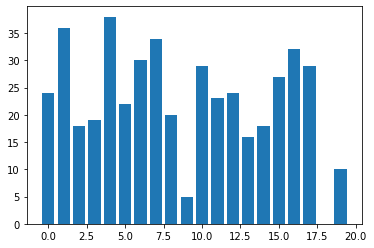

In [91]:
#클러스터별 분포 확인
plt.bar(cluster_ls.value_counts().index, cluster_ls.value_counts().values)

In [92]:
df = pd.DataFrame({'cluster_name' : cluster_ls, 'cluster_proba' : cluster_proba})
df = df.reset_index()
df

,index,cluster_name,cluster_proba
0,0,1,1.000000
1,1,4,0.999749
2,2,7,0.999999
3,3,12,0.995210
4,4,3,0.999850
...,...,...,...
449,449,16,0.999952
450,450,1,1.000000
451,451,12,0.999999
452,452,5,0.997907


In [40]:
os.listdir('../../3jo_project/cluster_dataframe')

['README.md', 'config', '.git', '이미지 모델', 'config1']

In [93]:
basic = pd.read_csv('../../3jo_project-1/크롤링/basic_table.csv')
basic = basic.reset_index()
basic_cluster = pd.merge(basic, df)
basic_cluster.to_csv('../../3jo_project/cluster_dataframe/basic_cluster.csv')
basic_cluster.head()

,index,name,writer,summary,genre,link2,cluster_name,cluster_proba
0,0,참교육,채용택 / 한가람,무너진 교권을 지키기 위해 교권보호국 소속 나화진의 참교육이 시작된다!<부활남> 채...,"스토리, 액션",https://shared-comic.pstatic.net/thumb/webtoon...,1,1.000000
1,1,신의 탑,SIU,자신의 모든 것이었던 소녀를 쫓아 탑에 들어온 소년그리고 그런 소년을 시험하는 탑,"스토리, 판타지",https://shared-comic.pstatic.net/thumb/webtoon...,4,0.999749
2,2,뷰티풀 군바리,설이 / 윤성원,'여자도 군대에 간다면?'본격 여자도 군대 가는 만화!,"스토리, 드라마",https://shared-comic.pstatic.net/thumb/webtoon...,7,0.999999
3,3,윈드브레이커,조용석,혼자서 자전거를 즐겨타던 모범생 조자현.원치 않게 자전거 크루의 일에 자꾸 휘말리게...,"스토리, 스포츠",https://shared-comic.pstatic.net/thumb/webtoon...,12,0.995210
4,4,팔이피플,매미 / 희세,"<마스크걸>, <위대한 방옥숙> 매미/희세 작가의 신작!SNS에서 육아용품 파는 평...","스토리, 드라마",https://shared-comic.pstatic.net/thumb/webtoon...,3,0.999850


# Example
- cluster 10

In [99]:
#url
url_cls10 = basic_cluster[basic_cluster.cluster_name == 9].link2.values
#cluster_probability
proba_cls10 = basic_cluster[basic_cluster.cluster_name==9].cluster_proba.values
proba_cls10 = map(lambda x : np.round(x, 2), proba_cls10)
proba_cls10 = np.array(list(proba_cls10))

#image
image_cls10 = np.zeros((len(url_cls10), 50, 50, 3))

for i in range(len(url_cls10)):
  image_nparray = np.asarray(bytearray(requests.get(url_cls10[i]).content)) #url
  image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) #image decode
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert bgr to rgb
  image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  image_cls10[i] = image

image_cls10 = image_cls10.astype('int32')
image_cls10.shape

(5, 50, 50, 3)

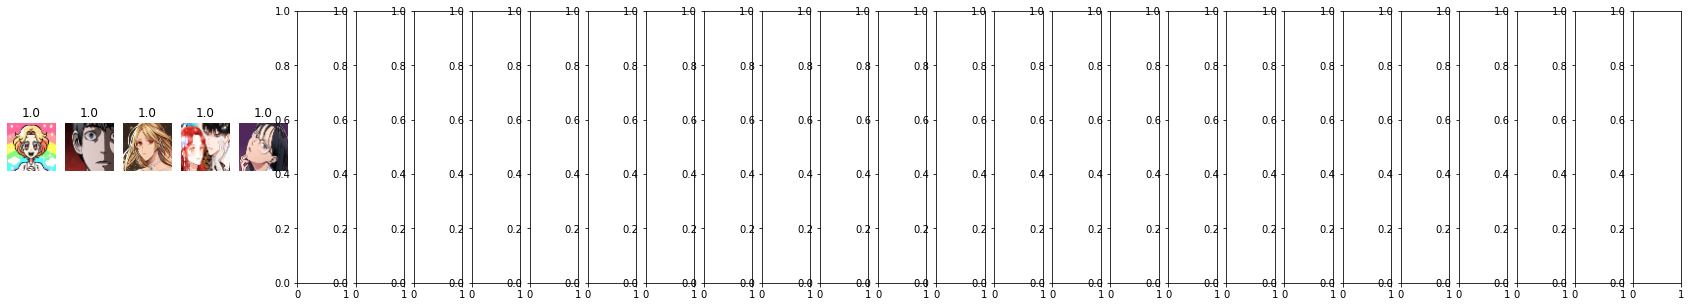

In [100]:
fig, ax = plt.subplots(figsize= (30, 5), nrows=1, ncols=29)

for i in range(len(image_cls10)):
    ax[i].imshow(image_cls10[i])
    ax[i].axis('off')
    ax[i].set_title('{}'.format(proba_cls10[i]))

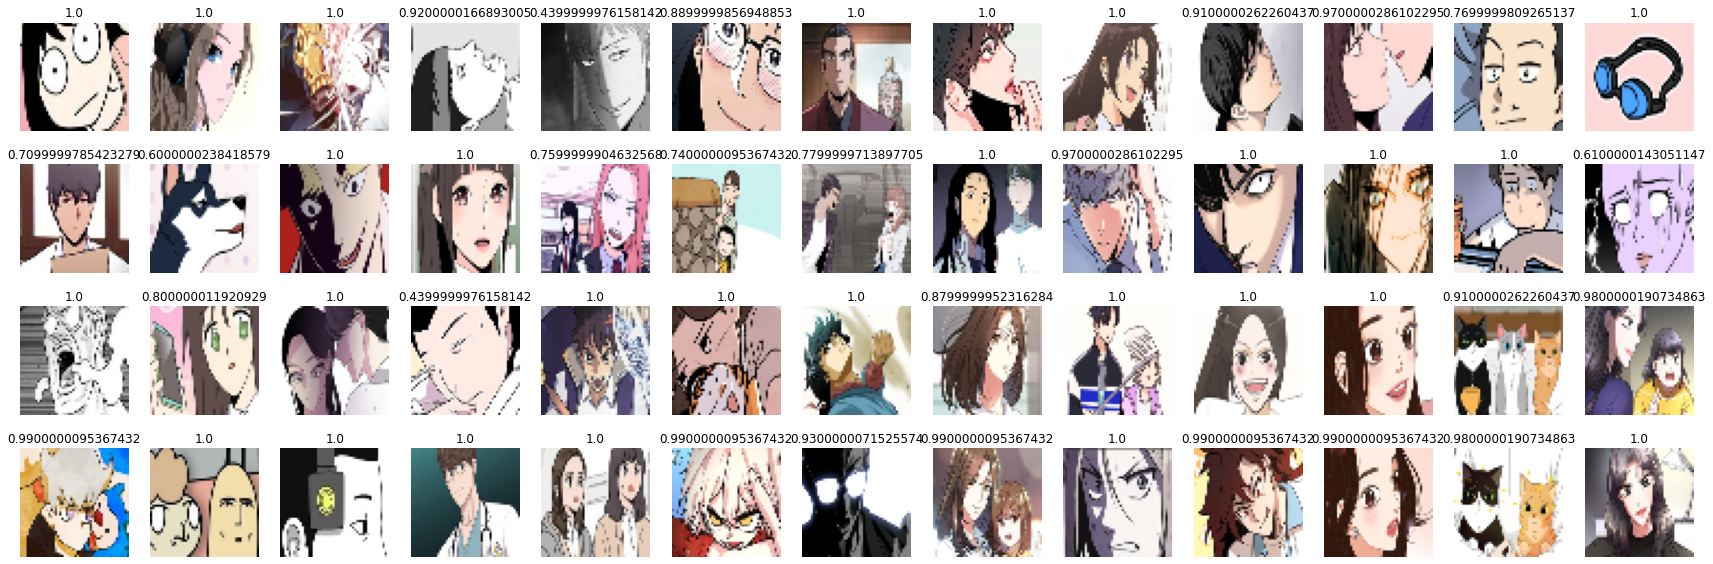

In [59]:
fig, ax = plt.subplots(figsize=(30, 10), nrows=4, ncols=13)

for i in range(int(len(image_cls10)/4)):
  ax[0, i].imshow(image_cls10[4*i])
  ax[0, i].axis('off')
  ax[0, i].set_title('{}'.format(proba_cls10[4*i]))
  ax[1, i].imshow(image_cls10[4*i+1])
  ax[1, i].axis('off')
  ax[1, i].set_title('{}'.format(proba_cls10[4*i+1]))
  ax[2, i].imshow(image_cls10[4*i+2])
  ax[2, i].axis('off')
  ax[2, i].set_title('{}'.format(proba_cls10[4*i+2]))
  ax[3, i].imshow(image_cls10[4*i+3])
  ax[3, i].axis('off')
  ax[3, i].set_title('{}'.format(proba_cls10[4*i+3]))